In [21]:
from collections import defaultdict
import os
import json
import sys
from decentralizepy.graphs.MobilityGraph import MobilityGraph
import numpy as np
import matplotlib.pyplot as plt    

from simulate_graph import simulate_graph


def average_of_first_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[:n])

def average_of_last_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[-n:])


num_nodes = 48
high_mobility_proportion = 0.8
graph=f"tutorial/dynamic_48_{str(high_mobility_proportion).replace(".", "_")}.txt"

graphs=simulate_graph(graph)

def high_mobility_nodes(g: MobilityGraph):
    n = int(len(g.nodes) * high_mobility_proportion)
    return g.nodes[:n]

def low_mobility_nodes(g: MobilityGraph):  
    n_low = int(len(g.nodes) * high_mobility_proportion)
    return g.nodes[n_low:]

graphs: list[MobilityGraph] = []
last_graph_file_number = find_last_graph_file(graphs_dir)
for i in range(1, last_graph_file_number + 1):
    file_path = os.path.join(graphs_dir, f"graph_{i}.txt")
    if os.path.exists(file_path):
        g = MobilityGraph()
        g.read_graph_from_file(file_path)
        graphs.append(g)
    else:
        print(f"File graph_{i}.txt does not exist in the directory.")
        sys.exit(1)

n = len(graphs)
high_mobility_neighbors = [defaultdict(set) for _ in range(n)]
low_mobility_neighbors = [defaultdict(set) for _ in range(n)]

for (i, g) in enumerate(graphs):
    h_nodes = high_mobility_nodes(g)
    l_nodes = low_mobility_nodes(g)

    print("High mobility nodes:", [node.uid for node in h_nodes])
    print("High mobility nodes velocities:", [node.velocity for node in h_nodes])
    print("Low mobility nodes:", [node.uid for node in l_nodes])
    print("Low mobility nodes velocities:", [node.velocity for node in l_nodes])

    for node in h_nodes:
        high_mobility_neighbors[i][node.uid] = set(g.neighbors(node.uid))
    
    for node in l_nodes:
        low_mobility_neighbors[i][node.uid] = set(g.neighbors(node.uid))
    


High mobility nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
High mobility nodes velocities: [142.0977812220579, 98.18681661521123, 127.15364231943813, 109.04788574447093, 100.1723329874473, 89.3242565525529, 161.02791722765124, 169.19277333266615, 151.07762082340443, 118.74008987534614, 123.70238382272535, 103.75249765899308, 133.89011256911328, 167.21046360782137, 174.147145758048, 105.063416648229, 102.50841884165938, 133.92449061846972, 105.28847141749458, 102.85033054725821, 154.14016715305496, 97.45806365431916, 91.58266025865044, 98.10967060495605, 131.46293436027244, 99.33644780085177, 156.69109589958035, 120.0830302432012, 157.9490359459335, 163.03909181932983, 122.97541025256552, 130.20190181571377, 133.8364018627529, 167.22594701812676, 114.80769946221088, 92.95810856273584, 96.8012920511202, 159.7835072983208]
Low mobility nodes: [38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Lo

In [22]:
average_high_mobility_velocity = [np.mean([node.velocity for node in high_mobility_nodes(g)]) for g in graphs][0]
average_low_mobility_velocity = [np.mean([node.velocity for node in low_mobility_nodes(g)]) for g in graphs][0]

print("Average High Mobility Velocity:", average_high_mobility_velocity)
print("Average Low Mobility Velocity:", average_low_mobility_velocity)

Average High Mobility Velocity: 126.49477142773038
Average Low Mobility Velocity: 37.45103333098418


[4.5, 4.973684210526316, 6.684210526315789, 5.7105263157894735, 6.052631578947368, 6.368421052631579, 4.894736842105263, 5.473684210526316, 4.7894736842105265, 6.526315789473684, 3.973684210526316, 5.421052631578948, 5.684210526315789, 5.0, 5.2368421052631575, 4.473684210526316, 4.2368421052631575, 5.2368421052631575, 4.078947368421052, 4.578947368421052, 4.026315789473684, 3.3947368421052633, 4.973684210526316, 4.0, 5.105263157894737, 4.7105263157894735, 3.5526315789473686, 5.131578947368421, 4.815789473684211, 3.973684210526316, 4.815789473684211, 4.0, 5.421052631578948, 7.552631578947368, 5.447368421052632, 5.105263157894737, 6.605263157894737, 6.368421052631579, 5.7631578947368425, 4.921052631578948, 5.052631578947368, 3.789473684210526, 2.8157894736842106, 3.763157894736842, 3.210526315789474, 5.157894736842105, 4.2631578947368425, 5.815789473684211, 5.815789473684211, 4.552631578947368, 4.631578947368421, 3.763157894736842, 4.578947368421052, 4.7368421052631575, 4.315789473684211

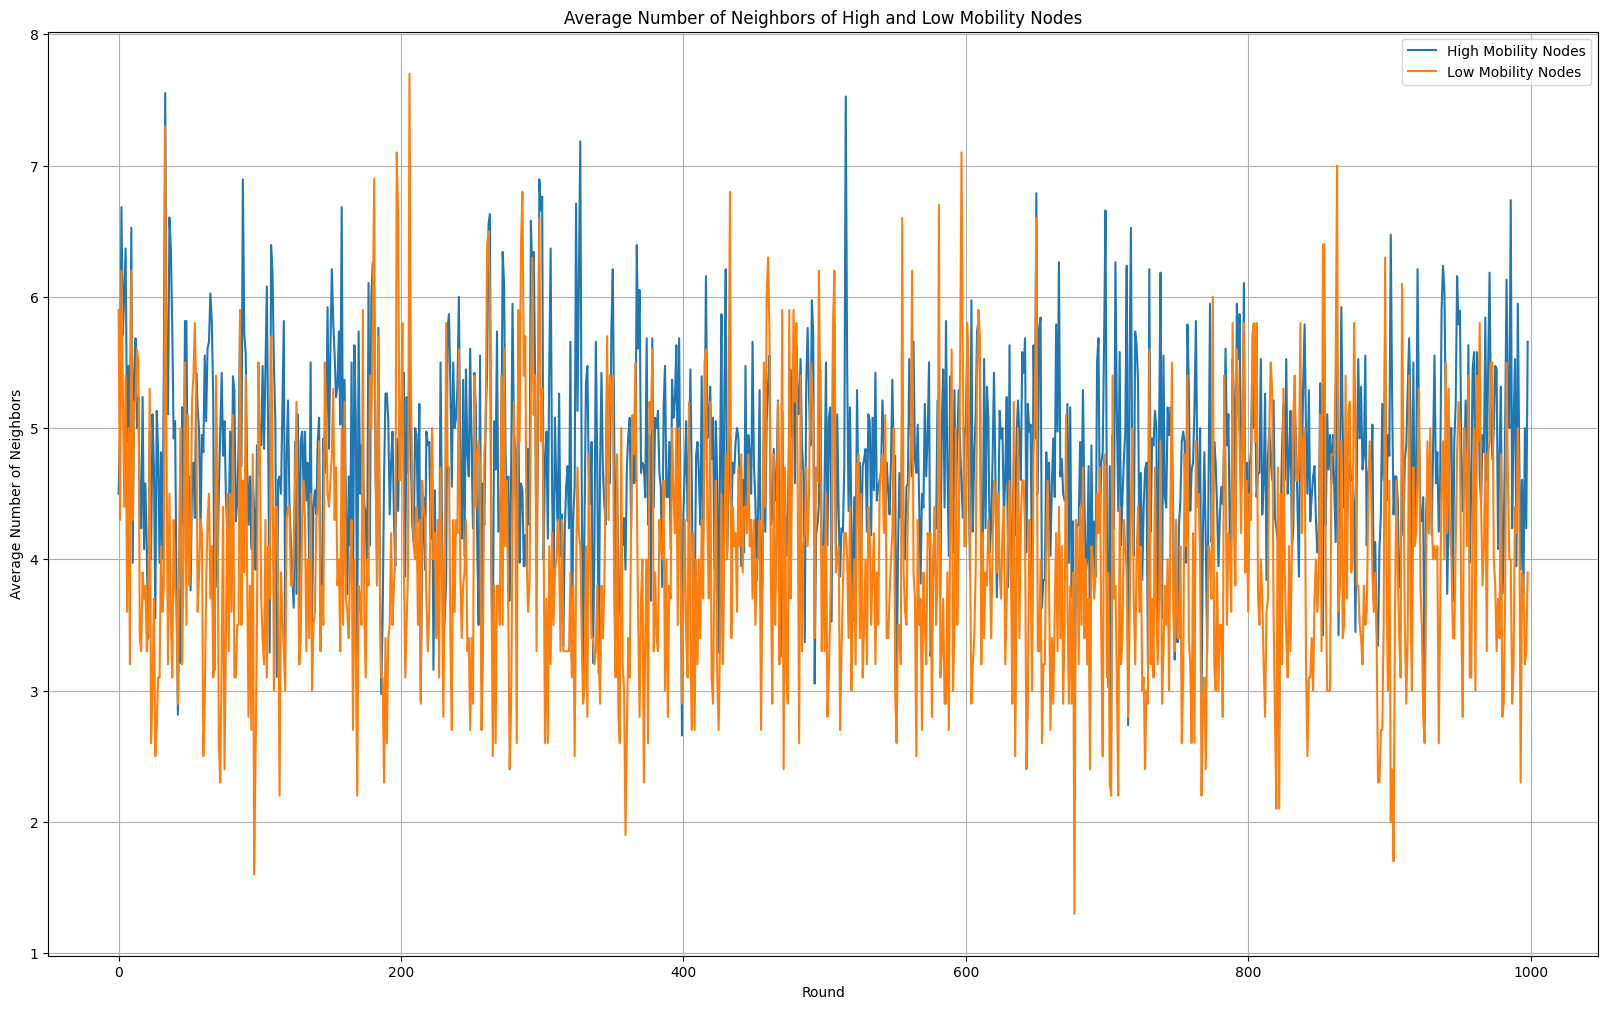

In [23]:
plt.figure(figsize=(20, 12))

average_num_neighbors_high_mobility = [np.mean([len(high_mobility_neighbors[i][node.uid]) for node in high_mobility_nodes(g)]) for i, g in enumerate(graphs)]
average_num_neighbors_low_mobility = [np.mean([len(low_mobility_neighbors[i][node.uid]) for node in low_mobility_nodes(g)]) for i, g in enumerate(graphs)]

print(average_num_neighbors_high_mobility)
print(average_num_neighbors_low_mobility)

plt.plot(average_num_neighbors_high_mobility, label="High Mobility Nodes")
plt.plot(average_num_neighbors_low_mobility, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Number of Neighbors")
plt.title("Average Number of Neighbors of High and Low Mobility Nodes")
plt.legend()
plt.grid(True)
plt.show()


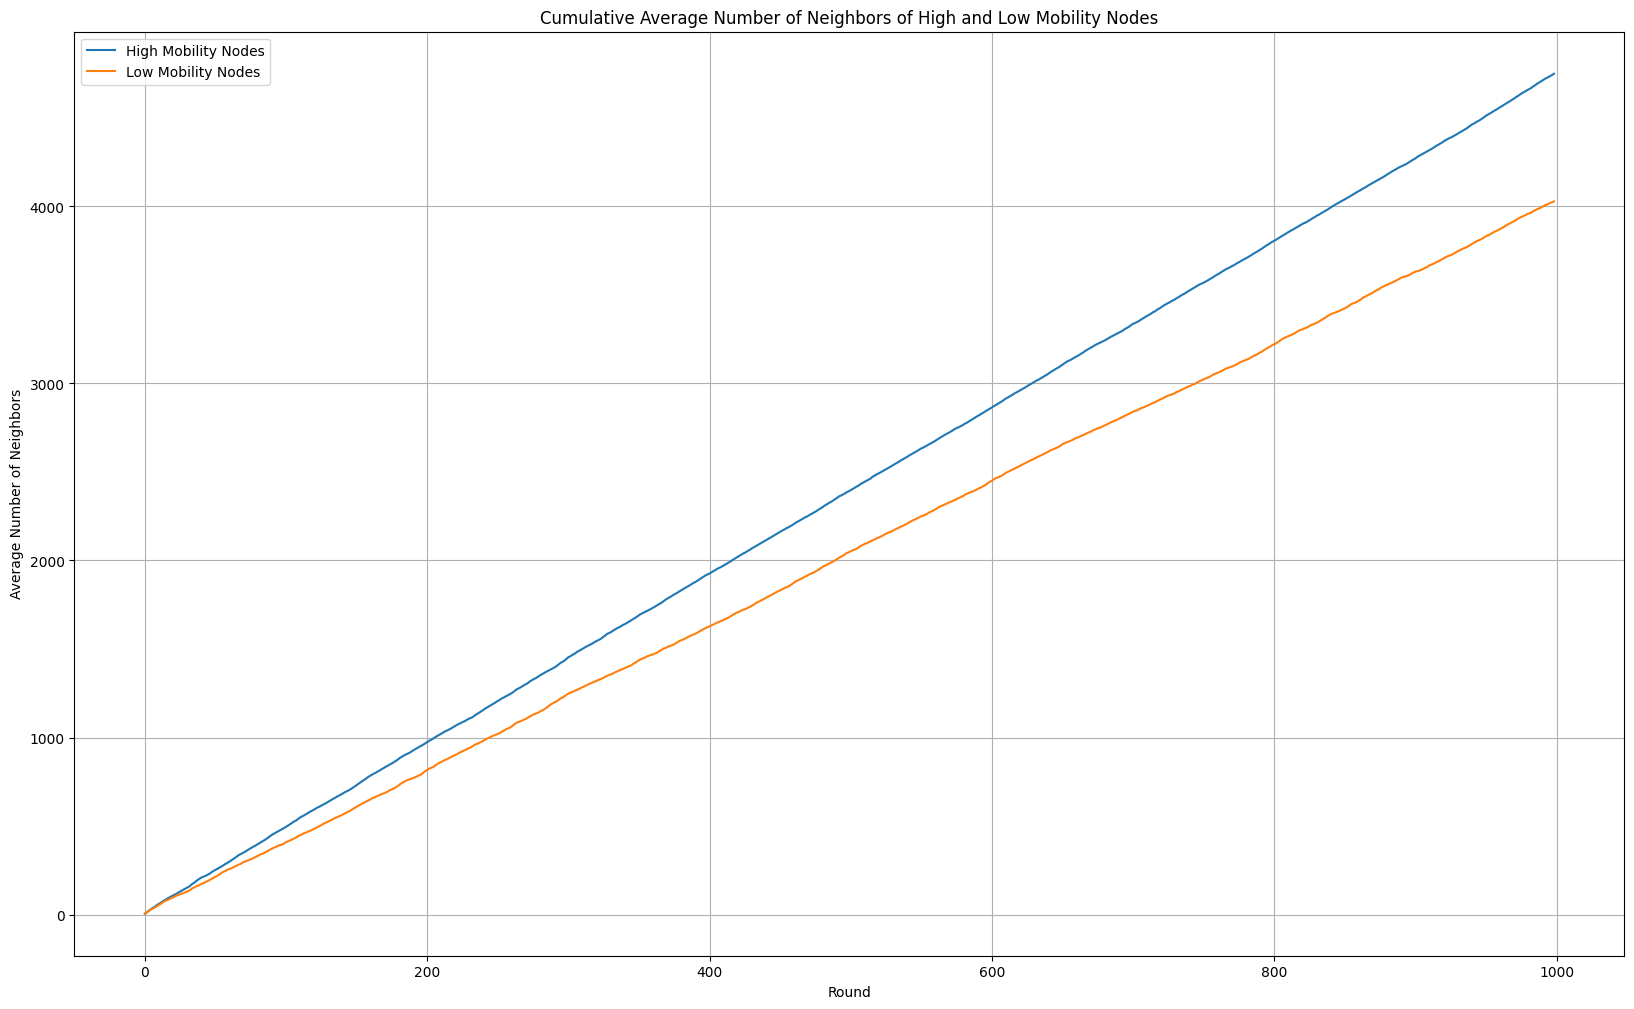

In [24]:
cumulative_num_neighbors_high_mobility = np.cumsum(np.array(average_num_neighbors_high_mobility))
cumulative_num_neighbors_low_mobility = np.cumsum(np.array(average_num_neighbors_low_mobility))

plt.figure(figsize=(20, 12))

plt.plot(cumulative_num_neighbors_high_mobility, label="High Mobility Nodes")
plt.plot(cumulative_num_neighbors_low_mobility, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Number of Neighbors")
plt.title("Cumulative Average Number of Neighbors of High and Low Mobility Nodes")
plt.legend()
plt.grid(True)


[164.12760678222378, 154.30161775133962, 213.29099338500095, 205.14160566366672, 174.02804512226376, 177.7045496916508, 162.7425644384017, 197.66419131965853, 158.01613585365584, 209.41144239288, 152.18211441944715, 188.94867119765354, 188.33698515698356, 177.47021126859582, 177.33287012493355, 147.717681482145, 176.6836157208743, 180.81186298196025, 184.55680307894087, 176.93724052994375, 196.28744371801326, 147.85206445567403, 202.0660679714302, 164.3860918687312, 169.84792707803845, 193.77805925869725, 174.68621546309342, 180.15276259628553, 188.64288267251285, 183.11335387868047, 195.01442656959145, 174.87235068206124, 173.26478675541878, 217.56215999385725, 158.73088583850836, 173.4546230722225, 190.87402929203694, 180.66057256291398, 185.89465072374168, 165.70044070604163, 200.78602284348872, 180.253586924963, 144.26523350449676, 151.94673112968997, 169.6717598296319, 180.63563976046572, 177.30779273248848, 178.72302037316217, 185.18119260344272, 173.3517887892893, 192.1403490322

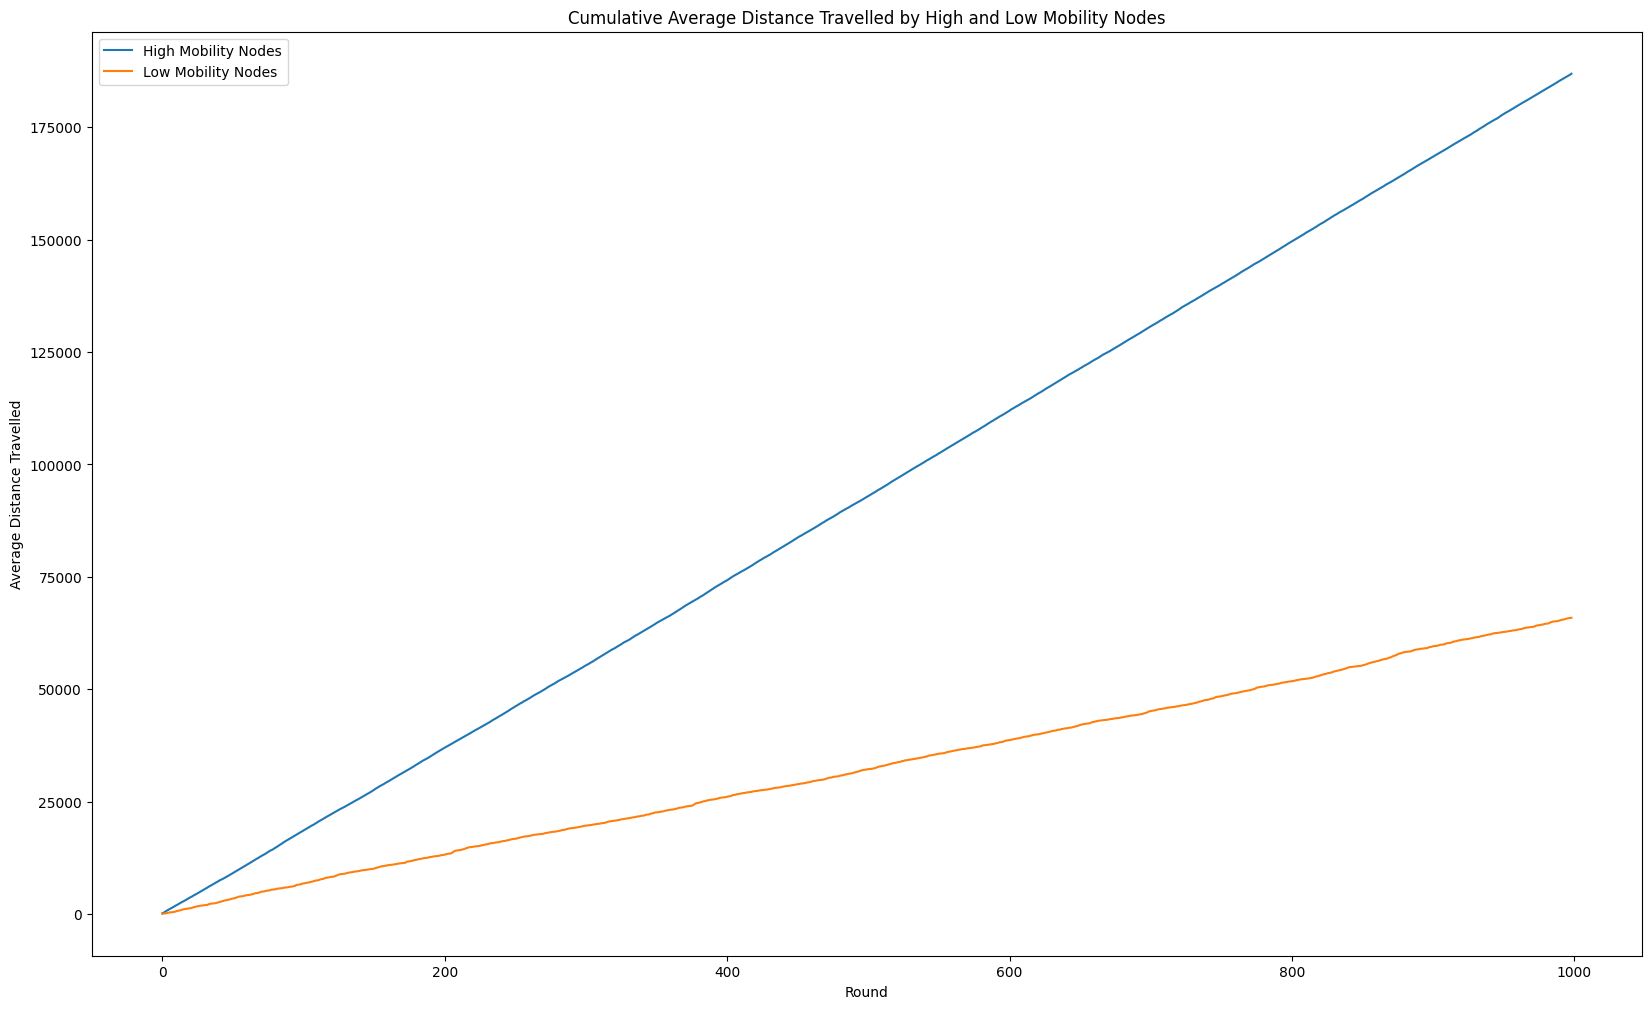

In [25]:
from decentralizepy.graphs.MobilityNode import MobilityNode


def get_node_distance_travelled(node: MobilityNode):
    return np.linalg.norm(np.array(node.pos_vec) - np.array(node.previous_pos_vec))

high_mobility_nodes_distances = [np.mean([get_node_distance_travelled(node) for node in high_mobility_nodes(g)]) for g in graphs]
low_mobility_nodes_distances = [np.mean([get_node_distance_travelled(node) for node in low_mobility_nodes(g)]) for g in graphs]
print(high_mobility_nodes_distances)
print(low_mobility_nodes_distances)

cum_high_mobility_nodes_distances = np.cumsum(np.array(high_mobility_nodes_distances))
cum_low_mobility_nodes_distances = np.cumsum(np.array(low_mobility_nodes_distances))

plt.figure(figsize=(20, 12))

plt.plot(cum_high_mobility_nodes_distances, label="High Mobility Nodes")
plt.plot(cum_low_mobility_nodes_distances, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Distance Travelled")
plt.title("Cumulative Average Distance Travelled by High and Low Mobility Nodes")
plt.legend()
plt.show()